In [1]:
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import csv
import numpy as np
from keras.models import Graph
from keras.layers.core import Dense
from keras.callbacks import Callback
import operator
import matplotlib.pyplot as plt

In [3]:
data_file = "kinship.csv"

In [4]:
relationships = []
people = []

with open(data_file, 'r') as f:
    for kinship in csv.DictReader(f):
        if kinship["relationship"] not in relationships:
            relationships.append(kinship["relationship"])
        if kinship["person1"] not in people:
            people.append(kinship["person1"])
        if kinship["person2"] not in people:
            people.append(kinship["person2"])

In [5]:
n = sum(1 for line in open(data_file)) - 1 # header row
p = len(people)
r = len(relationships)

X_person1 = np.zeros((n, p), dtype='uint8')
X_relationship  = np.zeros((n, r), dtype='uint8')
y_person2 = np.zeros((n, p), dtype='uint8')

with open(data_file, 'r') as f:
    for i, kinship in enumerate(csv.DictReader(f)):
        X_person1[i][people.index(kinship['person1'])] = 1
        X_relationship[i][relationships.index(kinship['relationship'])] = 1
        y_person2[i][people.index(kinship['person2'])] = 1

In [6]:
graph = Graph()

graph.add_input(name='person1', input_shape=(X_person1.shape[1],))
graph.add_node(Dense(6, activation='sigmoid', init='normal'), name='person1_learned_encoding', input='person1') 

graph.add_input(name='relationship', input_shape=(X_relationship.shape[1],))
graph.add_node(Dense(6, activation='sigmoid', init='normal'), name='relationship_learned_encoding', input='relationship')

graph.add_node(Dense(12, activation='sigmoid', init='normal'), name='predicted_features', inputs=['person1_learned_encoding', 'relationship_learned_encoding'])

graph.add_node(Dense(6, activation='sigmoid', init='normal'), name='person2_learned_encoding', input='predicted_features') 

graph.add_node(Dense(y_person2.shape[1], activation='softmax', init='normal'), name='person2', input='person2_learned_encoding')
graph.add_output(name='output', input='person2')

graph.compile('sgd', {'output': 'mse'})

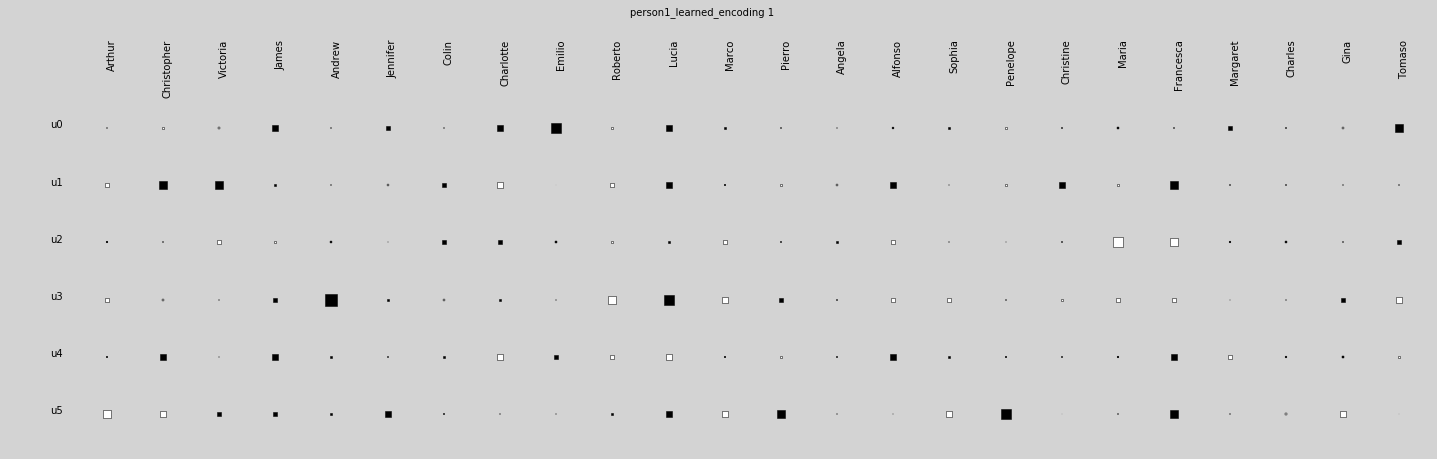

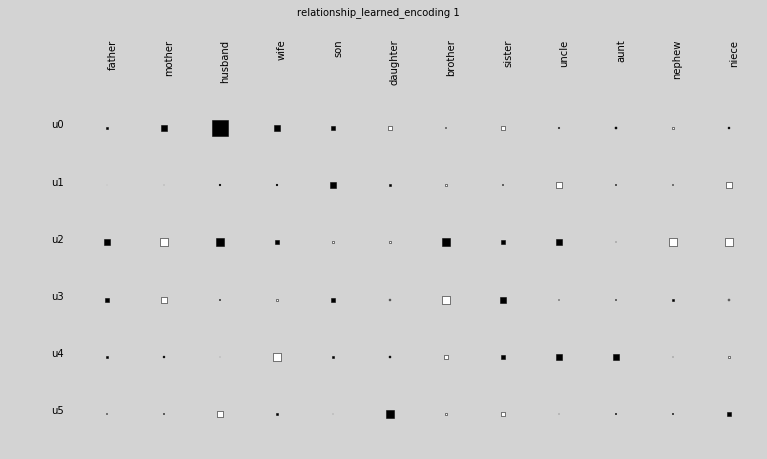

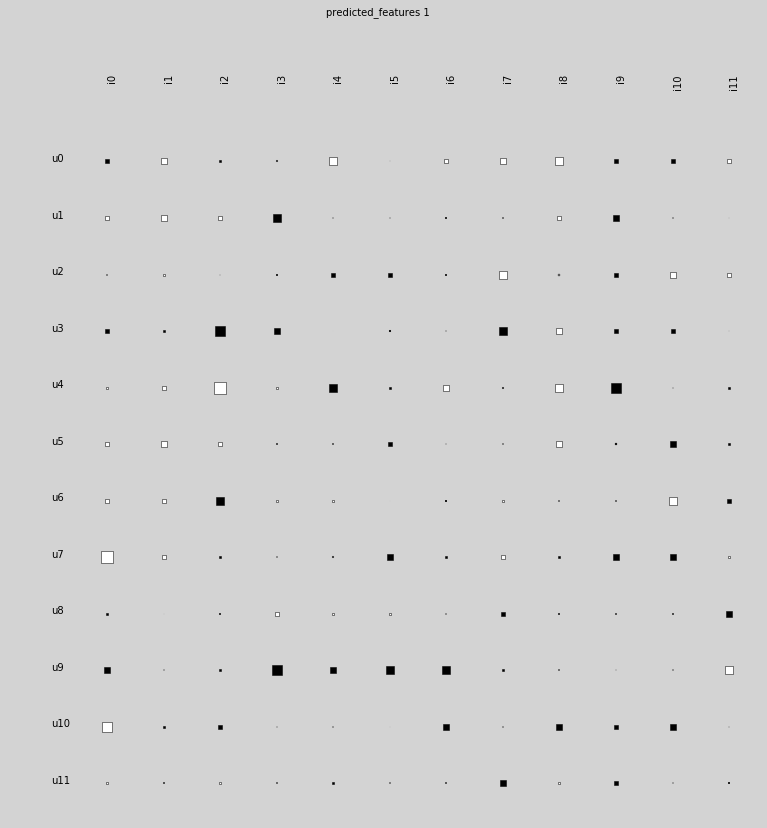

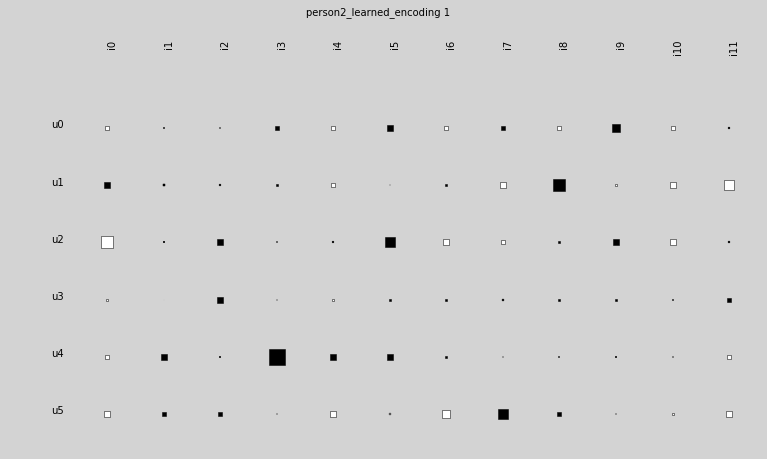

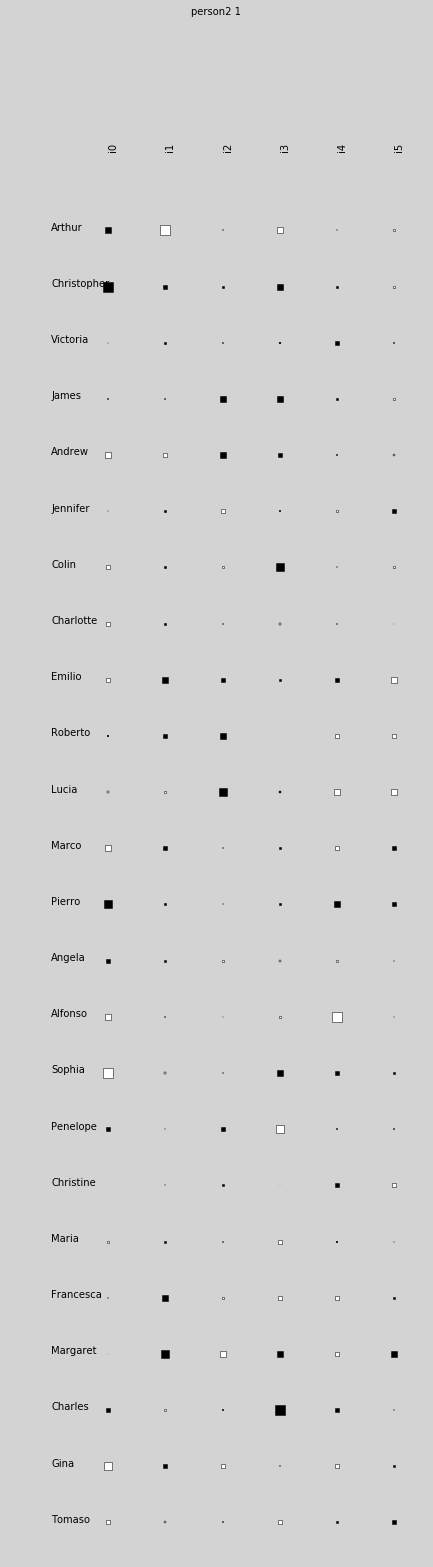

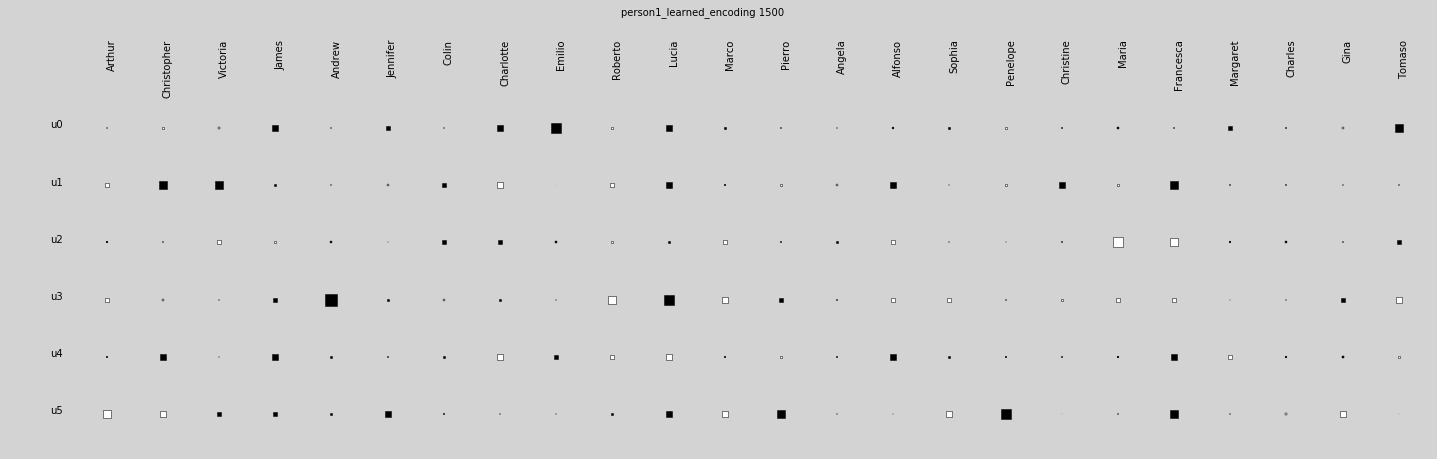

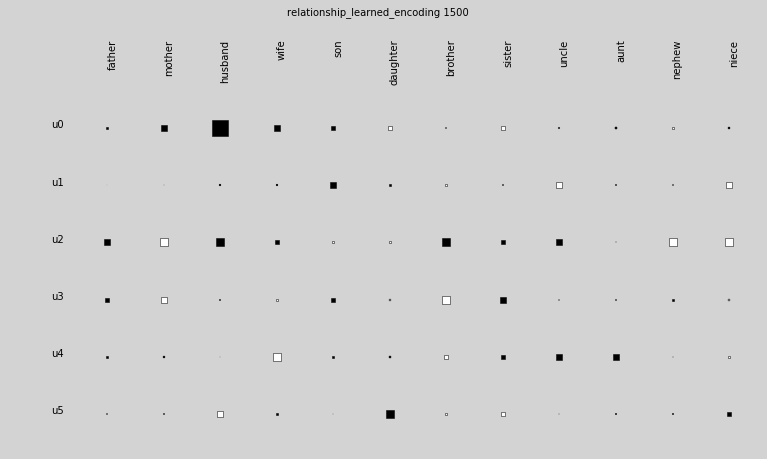

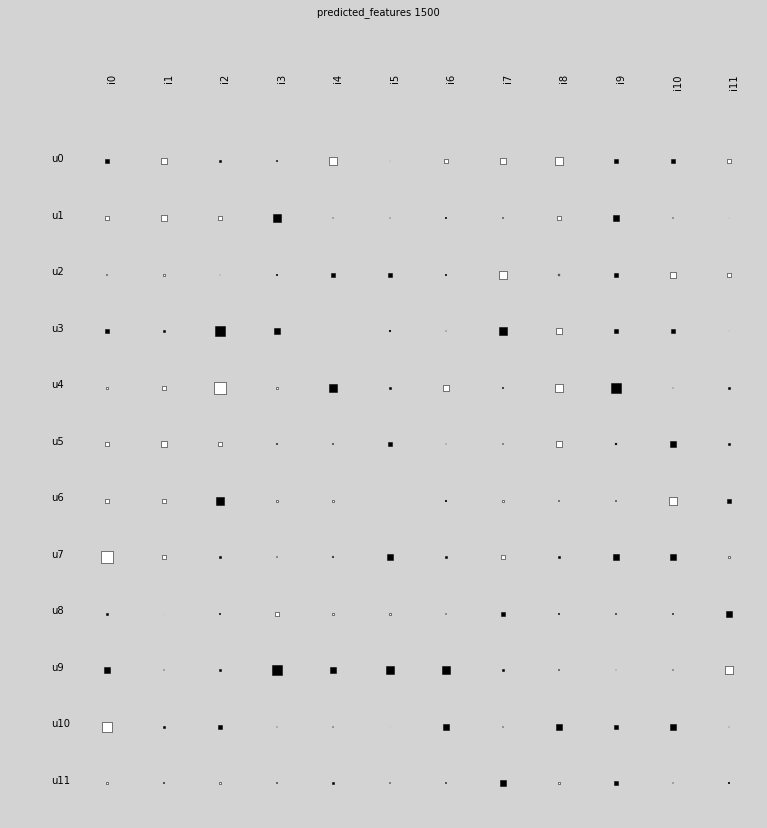

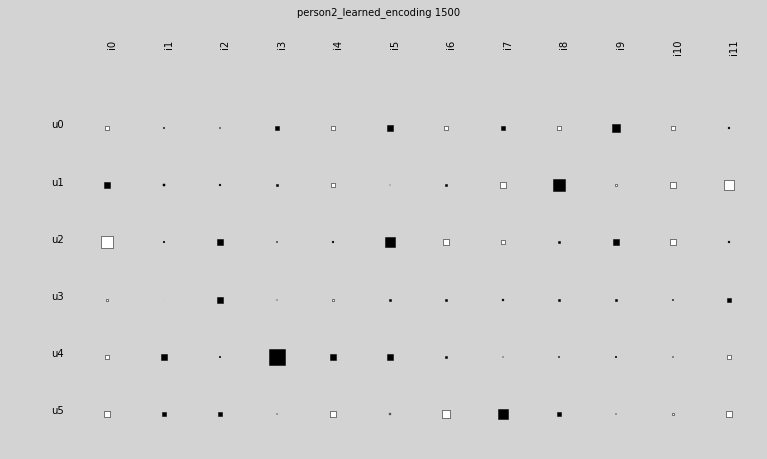

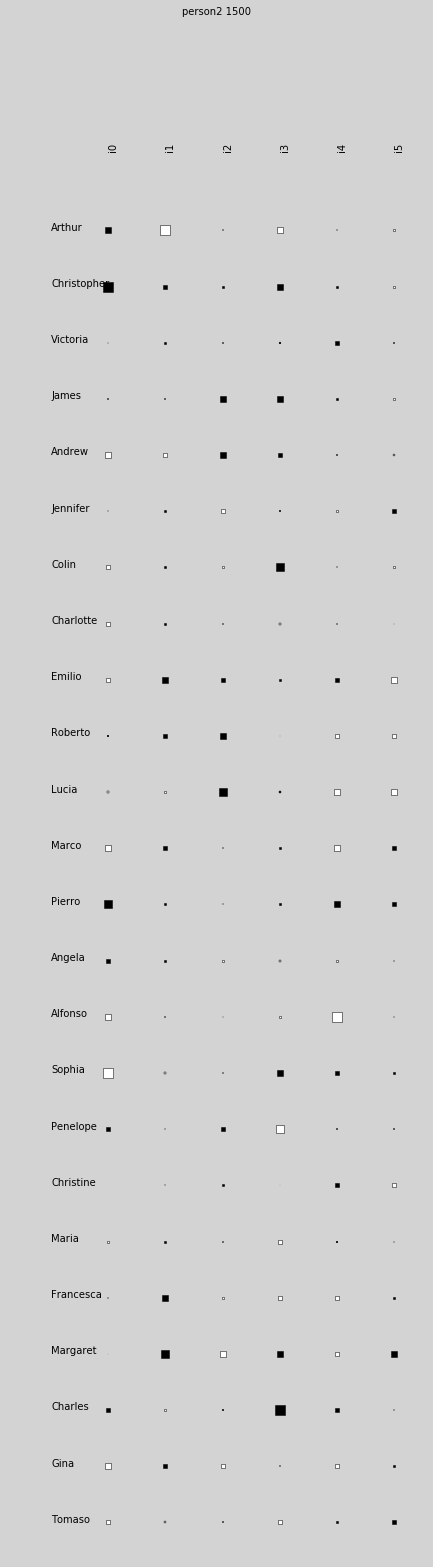

In [7]:
def visualize(weights, title=None, unit_labels=None, input_labels=None):
    num_units = len(weights[0][0])
    num_inputs = len(weights[0])

    if input_labels is None:
        input_labels = []
        for n in range(0, num_inputs):
            input_labels.append("i{0}".format(n))

    if unit_labels is None:
        unit_labels = []
        for n in range(0, num_units):
            unit_labels.append("u{0}".format(n))

    fig, axes = plt.subplots(ncols=num_inputs + 1, nrows=num_units + 1, figsize=(num_inputs + 1, num_units + 1)) # +1 header
    fig.patch.set_facecolor("lightgray")
    
    # upper left corner; always blank
    ax = axes[0][0]
    ax.set_axis_off()                                    
    
    for n, input_label in enumerate(input_labels):
        ax = axes[0][n + 1]
        ax.text(.5, 1, input_label, rotation="vertical")
        ax.set_axis_off()
        
    for i, unit_index in enumerate(range(0, num_units)):
        ax = axes[i + 1][0]
        ax.text(.5, .5, unit_labels[i])
        ax.set_axis_off()                                
        for j, w in enumerate(weights[0]):
            ax = axes[i + 1][j + 1]
            markersize = abs(w[unit_index]) * 90 # will only work for sigmoid (0 to 1 range)
            if w[unit_index] < 0:
                color="black"
            else:
                color="white"
            ax.plot(i, marker="s", markersize=markersize, linestyle=':', color=color)
            ax.margins(0.2)
            ax.set_axis_off()

    if title:
        plt.suptitle(title)

class Peek(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 0 or epoch == self.params['nb_epoch'] - 1:
            visualize(self.model.nodes["person1_learned_encoding"].get_weights(), title="person1_learned_encoding {0}".format(epoch + 1), input_labels=people)
            visualize(self.model.nodes["relationship_learned_encoding"].get_weights(), title="relationship_learned_encoding {0}".format(epoch + 1), input_labels=relationships)
            visualize(self.model.nodes["predicted_features"].get_weights(), title="predicted_features {0}".format(epoch + 1))
            visualize(self.model.nodes["person2_learned_encoding"].get_weights(), title="person2_learned_encoding {0}".format(epoch + 1))
            visualize(self.model.nodes["person2"].get_weights(), title="person2 {0}".format(epoch + 1), unit_labels=people)
            
history = graph.fit({'person1':X_person1, 'relationship':X_relationship, 'output':y_person2}, 
                    verbose=0, batch_size=n, validation_split=0.035398, nb_epoch=1500, callbacks=[Peek()])

In [8]:
predictions = graph.predict({'person1':X_person1, 'relationship':X_relationship})

In [9]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for i, row in enumerate(self):
            html.append("<tr>")
            for col in row:
                if i == 0:
                    html.append("<th>{0}</th>".format(col))                    
                else:
                    html.append("<td>{0}</td>".format(col))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

table = ListTable()
header = ['person1', 'relationship', 'person2']
header.extend(people)
table.append(header)

for i, prediction in enumerate(predictions['output']):
    person1 = people[X_person1[i].tolist().index(1)]
    relationship = relationships[X_relationship[i].tolist().index(1)]
    person2 = people[y_person2[i].tolist().index(1)]
    row = [person1, relationship, person2]
    row.extend(prediction)
    table.append(row)    

table

person1,relationship,person2,Arthur,Christopher,Victoria,James,Andrew,Jennifer,Colin,Charlotte,Emilio,Roberto,Lucia,Marco,Pierro,Angela,Alfonso,Sophia,Penelope,Christine,Maria,Francesca,Margaret,Charles,Gina,Tomaso
Arthur,father,Christopher,0.0453612990288,0.0374869997562,0.0409793928302,0.0396798525464,0.04272239843,0.0419641406528,0.0415947448648,0.0426291989233,0.0405262812705,0.0413717764371,0.0435848900658,0.0419802965249,0.0367160481371,0.0422508239348,0.0467046475604,0.0421278716999,0.0425235282301,0.0417150619268,0.0421245909117,0.0421325807972,0.0393166700195,0.0384124880147,0.0433146865877,0.0427797308492
Victoria,father,Christopher,0.0453615575563,0.0374871331095,0.0409793406545,0.0396799985351,0.0427225285714,0.0419640602394,0.0415946063852,0.0426291045422,0.0405261436852,0.0413717762965,0.0435849953468,0.0419802000554,0.0367161984034,0.0422507854788,0.0467045438585,0.0421278235819,0.0425236476463,0.0417151061366,0.0421245665296,0.0421324504406,0.0393165212534,0.0384126516597,0.043314479803,0.0427797802307
James,father,Andrew,0.045361538128,0.037487349621,0.0409793858774,0.0396801494341,0.042722538549,0.0419639407977,0.0415945582501,0.0426290598882,0.0405262852136,0.041371863283,0.0435850576638,0.0419800749926,0.0367163602788,0.0422507569906,0.0467042818023,0.0421277234925,0.042523731647,0.0417151991808,0.0421245771358,0.0421323512173,0.0393164109967,0.0384127776541,0.0433142980213,0.0427797298841
Jennifer,father,Andrew,0.0453614340533,0.0374872654515,0.0409794146921,0.0396800242414,0.0427224144979,0.0419640658126,0.0415946562068,0.0426291093827,0.0405262597631,0.0413717840122,0.0435848777859,0.041980147629,0.0367163353187,0.0422508140195,0.0467043493465,0.0421277847778,0.0425236237299,0.041715131187,0.0421245709139,0.0421324609272,0.0393165952036,0.0384127195764,0.043314447507,0.0427797139639
Colin,father,James,0.0453614466235,0.0374871460587,0.0409793990349,0.0396799647688,0.0427224369377,0.0419641007996,0.041594695078,0.042629135486,0.0405262238086,0.0413717429973,0.0435848771692,0.0419801975086,0.0367162268548,0.0422508072682,0.0467044776285,0.0421278561511,0.0425235718684,0.0417151043068,0.0421245677557,0.0421324822703,0.0393166063971,0.0384126559752,0.0433145335241,0.042779743729
Charlotte,father,James,0.0453611486535,0.0374871649178,0.0409794707289,0.0396798288963,0.0427221858259,0.0419642042588,0.0415947661876,0.0426292104507,0.0405263551108,0.0413717843316,0.0435846762591,0.0419802592096,0.0367162548059,0.0422509158608,0.0467044359682,0.0421277662617,0.0425235375764,0.0417150519559,0.0421246047508,0.0421326719667,0.0393168493892,0.0384125393515,0.0433146712363,0.042779646046
Emilio,father,Roberto,0.0453612548182,0.0374872394361,0.0409794185355,0.0396799790318,0.0427223664108,0.0419640370783,0.0415946437,0.0426291510842,0.0405263960029,0.041371910187,0.0435849541246,0.0419801936207,0.0367162280009,0.0422508336698,0.0467044047214,0.0421276887667,0.04252367014,0.0417151306115,0.0421246113953,0.0421325387301,0.0393166061001,0.0384125791993,0.0433145032735,0.0427796613612
Lucia,father,Roberto,0.0453614053967,0.0374873233835,0.0409794424356,0.0396799820674,0.04272229119,0.0419641199666,0.0415946355254,0.0426291225588,0.0405262485336,0.0413717744567,0.0435847466658,0.0419801346905,0.036716439873,0.0422508829381,0.0467042782909,0.0421277153255,0.0425236603653,0.0417151133637,0.0421245891728,0.0421325358399,0.0393166963061,0.0384127173953,0.0433144506735,0.0427796935851
Marco,father,Pierro,0.0453613210194,0.037486995513,0.0409793428071,0.0396798794575,0.0427224672588,0.0419640791274,0.0415946546048,0.0426291827089,0.0405262777251,0.041371870692,0.0435850427628,0.0419803095602,0.0367159871037,0.0422508076275,0.0467047120562,0.0421277929697,0.0425236230861,0.0417150708195,0.0421246060928,0.0421325740767,0.0393165856966,0.0384124362849,0.0433146448101,0.0427797361391
Angela,father,Pierro,0.0453613695542,0.0374871173064,0.040979412798,0.0396799128435,0.0427223784843,0.0419641412387,0.0415947289251,0.0426291608207,0.040